# Numpy elegance and curve smoothing

I recently came across a [blog](http://www.swharden.com/blog/2008-11-17-linear-data-smoothing-in-python/) where smoothing of data was discussed. The following function was used to smooth a data set with a Gaussian kernel. Read the blog to see what it is doing. Our previous implementation of data smoothing was using a tophat kernet with a window of 3 points. See [here](http://scikit-learn.org/stable/modules/density.html) for more details.

In [1]:
def smoothListGaussian(list,degree=5):
    list =[list[0]]*(degree-1) + list + [list[-1]]*degree
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)  
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    for i in range(len(smoothed)):  
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
    return smoothed  

This function is syntactically correct and it works. Let's test it with a data set. The same one used in the scipy cookbook (http://wiki.scipy.org/Cookbook/FiltFilt)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

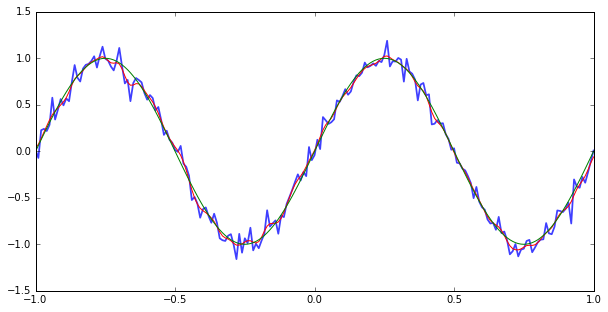

In [12]:
# Generate a noisy signal to be filtered.
t = np.linspace(-1, 1, 201)
x = np.sin(2 * np.pi * t)
xn = x + np.random.normal(size=len(t)) * 0.08
# Make the plot.
plt.figure(figsize=(10,5))
plt.plot(t, xn, 'b', linewidth=1.75, alpha=0.75)
list_xn = list(xn)
original = smoothListGaussian(list_xn)
plt.plot(t, original, 'r');
plt.plot(t, x, 'g');

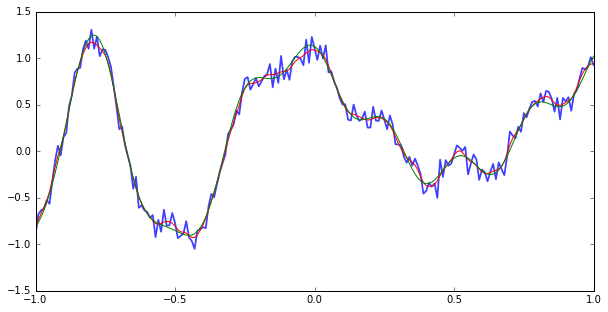

In [4]:
# Generate a noisy signal to be filtered.
t = np.linspace(-1, 1, 201)
x = (np.sin(2 * np.pi * 0.75 * t*(1-t) + 2.1) + 0.1*np.sin(2 * np.pi * 1.25 * t + 1) +
    0.18*np.cos(2 * np.pi * 3.85 * t))
xn = x + np.random.randn(len(t)) * 0.08
# Make the plot.
plt.figure(figsize=(10,5))
plt.plot(t, xn, 'b', linewidth=1.75, alpha=0.75)
list_xn = list(xn)
original = smoothListGaussian(list_xn)
plt.plot(t, original, 'r');
plt.plot(t, x, 'g');

Despite working, this code has several shortcomming. Our task here will be to improve the code for readability and efficiency. Because [premature optimization is the source of all evil](http://en.wikipedia.org/wiki/Program_optimization#When_to_optimize) we will first focus on just making the code more clear and elegant. A first look at the code shows:
* It is not documented.
* It uses lists instead of numpy arrays in many places.
* It uses `list` which is a [python built-in function](https://docs.python.org/3/library/functions.html) to name a variable.
* It modifies the value of the loop variable `i`.

Let's create our new function to solve the first 3 issues.

In [4]:
def smoothListGaussian2(myarray, degree=5):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    myarray = np.hstack([ [myarray[0]]*(degree-1),myarray,[myarray[-1]]*degree])
    window=degree*2-1  
    # Build the weights filter
    weight=np.array([1.0]*window)
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=np.exp(-(4*frac)**2)
        weightGauss.append(gauss)  
    weight=np.array(weightGauss)*weight
    # create the smoothed array with a convolution with the window
    smoothed=np.array([0.0]*(len(myarray)-window))
    for i in range(len(smoothed)):  
        smoothed[i]=sum(myarray[i:i+window]*weight)/sum(weight)  
    return smoothed

Now we check if it works and it gives the same result:

In [5]:
np.all(original-smoothListGaussian2(xn)==0)

True

For clarity, we can use Numpy functions `ones`, and `zeros` to create some of the arrays. [`pad`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html) will also be useful to pad the array instead of using `hstack`. Sometimes it's enough to know English to guess the existence of certain functions, such as pad.

In [6]:
def smoothListGaussian3(myarray, degree=5):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    myarray = np.pad(myarray, (degree-1,degree), mode='edge')
    window=degree*2-1  
    # Build the weights filter
    weight=np.ones(window)
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=np.exp(-(4*frac)**2)
        weightGauss.append(gauss)  
    weight=np.array(weightGauss)*weight
    # create the smoothed array with a convolution with the window
    smoothed=np.zeros((len(myarray)-window))
    for i in range(len(smoothed)):  
        smoothed[i]=sum(myarray[i:i+window]*weight)/sum(weight)  
    return smoothed

#Checking...
print("Still getting the same results...? ",np.all(original-smoothListGaussian3(xn)==0))

Still getting the same results...?  True


Modifying the value of the loop varible `i` is also rather ugly. We could directly define `frac` correctly. 

Looking closer at this loop, we see that `weightGauss` and `weight` are, after all, the same thing. Why don't we directly fill the values of `weight`? We do not need `weightGauss`.

In [7]:
def smoothListGaussian4(myarray, degree=5):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    myarray = np.pad(myarray, (degree-1,degree), mode='edge')
    window=degree*2-1  
    # Build the weights filter
    weight=np.ones(window)
    for i in range(window):  
        frac=(i-degree+1)/float(window)  
        weight[i] = np.exp(-(4*frac)**2)
    # create the smoothed array with a convolution with the window
    smoothed=np.zeros((len(myarray)-window))
    for i in range(len(smoothed)):  
        smoothed[i]=sum(myarray[i:i+window]*weight)/sum(weight)  
    return smoothed

#Checking...
print("Still getting the same results...? ",np.all(original-smoothListGaussian4(xn)==0))

Still getting the same results...?  True


At this point, we see that the values of the `weight` array only depend on `i`, not on previous values. So that we can create them with an array funcion. The `i` values go from `-degree+1` to `degree`. That is, if our degree is 3 we want a range from -2 to 2. Then, we will have `degree*2-1` = 5 windows centered around 0. That's all we need to know to remove that loop.

In [8]:
def smoothListGaussian5(myarray, degree=5):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    myarray = np.pad(myarray, (degree-1,degree), mode='edge')
    window=degree*2-1  
    # Build the weights filter
    weight=np.arange(-degree+1, degree)/window
    weight = np.exp(-(16*weight**2))
    weight /= weight.sum()
    # create the smoothed array with a convolution with the window
    smoothed=np.zeros((len(myarray)-window))
    for i in range(len(smoothed)):  
        smoothed[i]=sum(myarray[i:i+window]*weight)/sum(weight)  
    return smoothed

#Checking...
print("Still getting the same results...? ",np.all(original-smoothListGaussian5(xn)==0))

Still getting the same results...?  False


Ooops! But we're not getting the same results any more! Let's plot the difference to see what is going on.

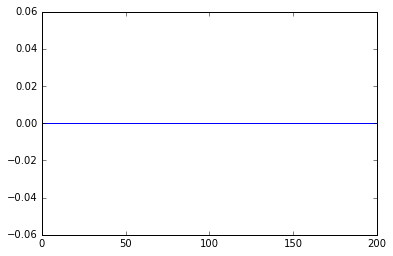

In [9]:
plt.plot(original-smoothListGaussian4(xn));

OK! So the results are not *exactly* the same but almost, due to floating point errors. We could plot the results each time, but we cal also use the numpy function [`allclose`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) to check for correctness:

In [10]:
print("Still getting the same results...? ",np.allclose(original, smoothListGaussian5(xn)))

Still getting the same results...?  True


Our last step of beautifying the code will be to check whether Numpy has a convolution function so that we do not need to do it in a for loop. Here, one cas to check the [documentation](http://docs.scipy.org/doc/numpy/reference/generated/numpy.convolve.html) to make sure the treatment of the boundaries is the same. We also needed to pad the initial array with one less element, to get the same final number of elements in `smoothed`.

In [11]:
def smoothListGaussian6(myarray, degree=5):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    myarray = np.pad(myarray, (degree-1,degree-1), mode='edge')
    window=degree*2-1  
    # Build the weights filter
    weight=np.arange(-degree+1, degree)/window
    weight = np.exp(-(16*weight**2))
    weight /= weight.sum()
    # create the smoothed array with a convolution with the window
    smoothed = np.convolve(myarray, weight, mode='valid')
    return smoothed

#Checking...
print("Still getting the same results...? ",np.allclose(original, smoothListGaussian6(xn)))

Still getting the same results...?  True


Just by making the code more elegant, we probably have improved its performance:

In [12]:
%timeit smoothListGaussian(list_xn)
%timeit smoothListGaussian2(xn)
%timeit smoothListGaussian3(xn)
%timeit smoothListGaussian4(xn)
%timeit smoothListGaussian5(xn)
%timeit smoothListGaussian6(xn)

100 loops, best of 3: 4.73 ms per loop
100 loops, best of 3: 4.01 ms per loop
100 loops, best of 3: 4.03 ms per loop
100 loops, best of 3: 3.35 ms per loop
100 loops, best of 3: 3.42 ms per loop
10000 loops, best of 3: 114 µs per loop


Sucess! We also see that the big change came from removing the loop that was performing the convolution.

Of course, if our real purpose was to Gaussian filter the data, we could have done some research to find `scipy.signal.gaussian` which would have directly created our window.

We could also check which convolution is more efficient. For such a small data this really makes no sense. But if you have to work with n-dimensional large arrays, the convolutions can become slow. Only then it makes sense to spend time optimizing. Googling for that, you can find the [Scipy Cookbook](http://wiki.scipy.org/Cookbook/ApplyFIRFilter) with valuable information on the subject. From that, we see that the apparently fastest convoution is `ndimage.convolve1d`. In our case, it reduces the CPU time by half, which is not bad. But I insist that one has to spend time with this when the actual time to be saved is macroscopic, not a few microseconds!

In [13]:
from scipy import signal, ndimage

In [14]:
# Here we check that the Gaussian window in the signal module is producing the same window 
# that we were manually doing
degree = 5
window=degree*2-1  
# Build the weights filter
weight=np.arange(-degree+1, degree)/window
weight = np.exp(-(16*weight**2))
print(weight)
print(signal.gaussian(window, std=window/np.sqrt(32)))

[ 0.0424048   0.16901332  0.45378877  0.82075481  1.          0.82075481
  0.45378877  0.16901332  0.0424048 ]
[ 0.0424048   0.16901332  0.45378877  0.82075481  1.          0.82075481
  0.45378877  0.16901332  0.0424048 ]


In [15]:
def smoothListGaussian7(myarray, degree=5):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    window=degree*2-1  
    # Build the weights filter
    weight = signal.gaussian(window, std=window/np.sqrt(32))
    weight /= weight.sum()
    # create the smoothed array with a convolution with the window
    smoothed = ndimage.convolve1d(myarray, weight, mode='nearest')
    return smoothed

#Checking...
print("Still getting the same results...? ",np.allclose(original, smoothListGaussian7(xn)))
%timeit smoothListGaussian7(xn)

Still getting the same results...?  True
10000 loops, best of 3: 103 µs per loop


Of course, if we wanted to perform a gaussian filtering we could directly call `ndimage.filters.gaussian_filter1d`. Remark that the results are not exactly the same, because here we do not determine the window size. However they are approximately equal.

In [16]:
%timeit ndimage.filters.gaussian_filter1d(xn, sigma=window/np.sqrt(32), mode='nearest')

10000 loops, best of 3: 70.1 µs per loop


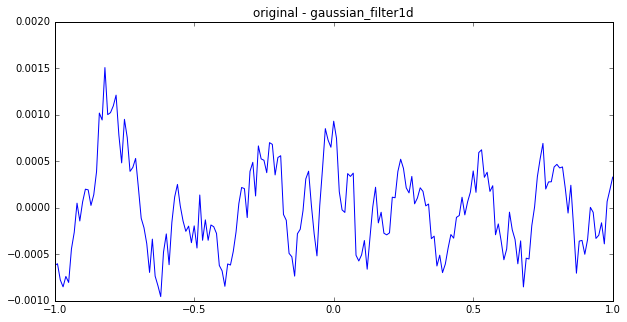

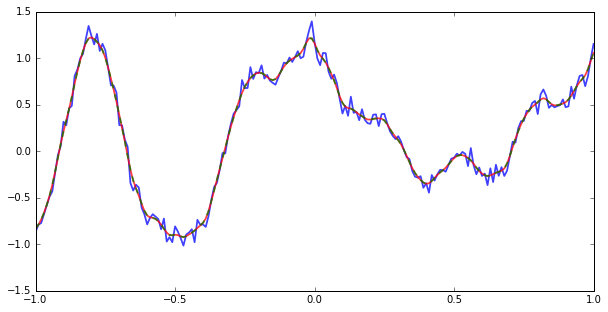

In [17]:
plt.figure(figsize=(10,5))
plt.plot(t, original-ndimage.filters.gaussian_filter1d(xn, sigma=window/np.sqrt(32), mode='nearest'));
plt.title('original - gaussian_filter1d')
plt.figure(figsize=(10,5));
plt.plot(t, xn, 'b', linewidth=1.75, alpha=0.75);
plt.plot(t, original, 'r-', linewidth=1.75, alpha=0.75);
plt.plot(t, ndimage.filters.gaussian_filter1d(xn, sigma=window/np.sqrt(32), mode='nearest'), 
         'g--',linewidth=1.75, alpha=0.75);

The take home message from this exercise is:

* Writing clear code usually results in efficient code.
* Numpy and scipy have lots of functions. Knowing some of them is pretty necessary, but not knowing all of them. Sometimes it is simpler to code something than to look for it.
* However, if the task you want to perform is crucial (for speed, for reliability, etc) it is worth spending some time looking for it. If it is a common scientific operation you will probably find it implemented in scipy.
* Using an Scipy/Numpy function is not only recommendable for the sake of speed. Those functions have been thoroughly tested by a large community and therefore are probably much more error-free that the one you code. 
* Therefore if you code things it is work contributing to Scipy, Numpy or the project you are using. You will not only help others, but others can help you spot bugs in your code, especially for situations that you did not consider (in your test cases), but that may appear during your research, when you rely on your code full-heartedly.

## Appendix: numba

Later in this course we will learn about [numba](http://numba.pydata.org/). For now, suffice it to say that numba compiles a python function using [LLVM compiler infrastructure](http://llvm.org/). In that case, python loops can be greatly accelerated and we do not need to try to substitute them with numpy array functions. It's use is very simple, just use the `@jit` decorator. In [this notebook](http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/NumbaCython.ipynb) by Jake Vanderplas, you can find more comparions about performace results. Visit [his blog](http://jakevdp.github.io/) for amazing stories about science and python.

In [18]:
from numba import jit

In [19]:
@jit
def smoothListGaussian_numba(myarray):
    """
    Given a 1D array myarray, the code returns a Gaussian smoothed version of the array.
    """
    # Pad the array so that the final convolution uses the end values of myarray and returns an
    # array of the same size
    degree = 5
    myarray = np.pad(myarray, (degree-1,degree), mode='edge')
    window = degree*2-1  
    # Build the weights filter
    weight=np.zeros(window) 
    for i in range(window):    
        frac=(i-degree+1)/window  
        weight[i]=np.exp(-(4*frac)**2)  
    weight /= weight.sum()
    # create the smoothed array with a convolution with the window
    smoothed=np.zeros(myarray.shape[0]-window)
    for i in range(smoothed.shape[0]):
        for j in range(window):
            smoothed[i] += myarray[i+j]*weight[j]
    return smoothed

print("Still getting the same results...? ",np.allclose(original, smoothListGaussian_numba(xn)))
%timeit smoothListGaussian_numba(xn)

Still getting the same results...?  True
10000 loops, best of 3: 106 µs per loop


In [10]:
np.random.normal?